<a href="https://colab.research.google.com/github/paulh20/covid_misc/blob/main/Copy_of_Copy_of_Casework_NLP_spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark

     |████████████████████████████████| 281.3 MB 36 kB/s 
     |████████████████████████████████| 198 kB 56.5 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=d00b40ad285e78f3b69cb51648bc4eaa90c7ce0542f7609e67d41db71d2bebd7
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


In [ ]:
# already done?
#!pip install pyarrow

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


Start by reading csv file as a pandas dataframe. This will hopefully get around the mysterious multi-row problem. 
Do some data cleaning of details fields (and concatenate) then change to spark for tokenisation (when dimensionality will explode)

In [1]:
# mount google drive 

from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
with open('./gdrive/MyDrive/iCasework data Apr-Oct-21_labelled_2.csv') as f:
    coding = f.encoding
    print(coding)

# read in data

data = pd.read_csv('./gdrive/MyDrive/iCasework data Apr-Oct-21_labelled_2.csv', encoding = 'cp1252')
data.head()



UTF-8


,Case id,Enquiry details,Details,Website or service request
0,8045649,NaN,I disagree with the decision made 14th June 20...,Service request
1,8528280,NaN,Sent from my iPhone,Service request
2,8411124,NaN,"Dear Sir / Madam,\nThis is just to remind you ...",Service request
3,6525405,HB enquiry,Good afternoon\nPlease find attached a letter ...,Service request
4,10194258,"Dear Althea,\nMs Juliana LeBlanc, 74 Lawrence ...","Dear Althea,\nMs Juliana LeBlanc, 74 Lawrence ...",Service request


In [ ]:
# check text of website queries
# data.loc[data['Website or service request']=='Website issue',['Details']].head(20)

In [ ]:
data[['Enquiry details','Details']] = data[['Enquiry details','Details']].astype('string')
data['Website or service request'] = data['Website or service request'].astype('category')
data.dtypes



Case id                          int64
Enquiry details                 string
Details                         string
Website or service request    category
dtype: object

In [ ]:
data.count()

Case id                       10157
Enquiry details                4286
Details                        6816
Website or service request     1012
dtype: int64

In [ ]:
# missing (na) entries - replace with blanks
data.loc[data.isnull()['Enquiry details'],['Enquiry details']]= ' '
data.loc[data.isnull()['Details'],['Details']]= ' '

In [ ]:
# add two text / comment fields together
data['Text'] = data['Details'] + data['Enquiry details']
data.drop(columns=['Enquiry details','Details'],inplace=True)
data1 = data

We now have a single column containing all comments.  
Next step is to 'clean up' the text.  
Remove punctuation and get to words with spaces, remove common stop words, remove capitalisation, etc.  


In [ ]:
# use nltk tools to pre-process Text field

# tokenise (convert to words)

# Import module
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import wordnet
# Create an instance of RegexpTokenizer for alphanumeric tokens
tokeniser = RegexpTokenizer(r'\w+')
# Tokenise 'Text' column

def to_tokens(x):
  return tokeniser.tokenize(x)

#data1['Tokens'] = data1['Text'].map(to_tokens)
#print(data1.Tokens.head())

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:

# Import module

# Create an instance of WordNetLemmatizer
lemmatiser = WordNetLemmatizer()
# function for Lowercase and lemmatise tokens
def lem(tokens):
  lemmas = [lemmatiser.lemmatize(token.lower(), pos='v') for token in tokens]
  return lemmas

#data1['Tokens'] = data1['Tokens'].map(lem)
#print(data1.Tokens)

In [ ]:
  def stop_words(text):
    keywords = [word for word in text if word not in stopwords.words('english')]
    return(keywords)

#  data1['Tokens'] = data1['Tokens'].map(stop_words)
#print(data1.Tokens)

In [ ]:
# data preprocessing text to words (tokens)
import re
def preprocess_text(text):
  text = re.sub(r'\d+', '', text) # remove numbers
  tokens = to_tokens(text)
  lemmas = lem(tokens)
  keywords = stop_words(lemmas)
  return keywords

# data1['Tokens2'] = data1.Text.map(preprocess_text)

# data1['Tokens'].equals(data1['Tokens2'])




In [ ]:
# Create an instance of TfidfVectorizer
vectoriser = TfidfVectorizer(strip_accents = 'unicode',
                             analyzer= preprocess_text,
                             max_features = 300)
# Fit to the data and transform to feature matrix
X_train = vectoriser.fit_transform(data['Text'])
# Convert sparse matrix to dataframe
X_train = pd.DataFrame.sparse.from_spmatrix(X_train)
# Save mapping on which index refers to which words
col_map = {v:k for k, v in vectoriser.vocabulary_.items()}
# Rename each column using the mapping
for col in X_train.columns:
    X_train.rename(columns={col: col_map[col]}, inplace=True)
X_train

,able,accept,accommodation,account,act,action,address,addressee,advise,also,alteration,althea,another,anti,anyone,appeal,application,april,area,ask,attach,attachments,attempt,aware,back,base,behalf,best,bid,bin,block,borough,brown,build,call,cannot,car,care,case,cause,...,tell,tenant,th,thank,therefore,think,time,timms,today,try,two,uk,unauthorised,understand,unless,update,us,use,view,virus,viruses,wait,walk,want,waste,water,way,website,well,west,wish,within,without,work,would,write,www,year,years,yet
0,0.261011,0.00000,0.000000,0.00000,0.000000,0.058402,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.148357,0.064903,0.0,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.071198,0.000000,0.00000,0.064774,...,0.000000,0.000000,0.123523,0.000000,0.0,0.000000,0.094901,0.000000,0.0,0.000000,0.000000,0.114259,0.0,0.0564,0.000000,0.0,0.000000,0.106533,0.00000,0.0,0.0,0.000000,0.156405,0.000000,0.000000,0.0,0.068547,0.0,0.0,0.000000,0.000000,0.000000,0.071258,0.000000,0.089389,0.000000,0.0,0.0000,0.063128,0.071813
1,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0000,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0000,0.000000,0.000000
2,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.292242,0.000000,0.0,0.0000,0.000000,0.0,0.247899,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.195486,0.000000,0.0,0.0000,0.276113,0.000000
3,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.18164,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.213304,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.481606,0.0,0.000000,0.000000,0.000000,0.0,0.0000,0.000000,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.216094,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0000,0.000000,0.000000
4,0.029221,0.02925,0.112951,0.03456,0.015261,0.000000,0.026567,0.0,0.025306,0.022363,0.0,0.031357,0.016362,0.0,0.0,0.000000,0.000000,0.0,0.031722,0.0,0.00000,0.0,0.0,0.032769,0.050600,0.031695,0.0,0.000000,0.086168,0.0,0.0,0.170148,0.062312,0.0,0.012531,0.0,0.000000,0.049591,0.01437,0.029006,...,0.025456,0.203275,0.000000,0.011657,0.0,0.015801,0.042498,0.000000,0.0,0.026793,0.000000,0.000000,0.0,0.0000,0.028394,0.0,0.114213,0.011927,0.02936,0.0,0.0,0.030568,0.000000,0.040653,0.000000,0.0,0.015348,0.0,0.0,0.061275,0.000000,0.055679,0.000000,0.099065,0.110080,0.025983,0.0,0.0293,0.113077,0.016079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10152,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0

In [ ]:
Xfeat = X_train.loc[(data['Website or service request']=='Website issue')|
                (data['Website or service request']=='Service request')]
#Xfeat

y = data.loc[(data['Website or service request']=='Website issue')|
            (data['Website or service request']=='Service request'),['Website or service request']]
y['Website or service request'].value_counts()

# data.loc[data.isnull()['Details'],['Details']]= ' '

Service request    901
Website issue      102
website issue        0
service request      0
Name: Website or service request, dtype: int64

In [ ]:
# split features and labels into train and validation sets
# use startified sampling due to class imbalance

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV

X_train, X_test, y_train, y_test = train_test_split(Xfeat, y, test_size=0.33, random_state=42, stratify = y)

X_train.shape

LR = LogisticRegressionCV(Cs=50,
                          fit_intercept=True,
                          cv=5,
                          dual=False,
                          penalty='l1',
                          solver='liblinear',
                          tol=0.0001,
                          max_iter=500,
                          class_weight='auto',
                          n_jobs=1,
                          verbose=0,
                          refit=True,
                          intercept_scaling=1.0,
                          multi_class='ovr')

mod = LR.fit(X_train,y_train)

mod

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegressionCV(Cs=50, class_weight='auto', cv=5, max_iter=500,
                     multi_class='ovr', n_jobs=1, penalty='l1',
                     solver='liblinear')

In [ ]:
print('Accuracy of fit to training data', mod.score(X_train, y_train))

Accuracy of fit to training data 0.9449404761904762


In [ ]:
print('Accuracy of fit to test data', mod.score(X_test, y_test))

Accuracy of fit to test data 0.9274924471299094


So, 95% accurate against training data and 93% against (unseen) test data.  
Lets also look at ROC



<function matplotlib.pyplot.show>

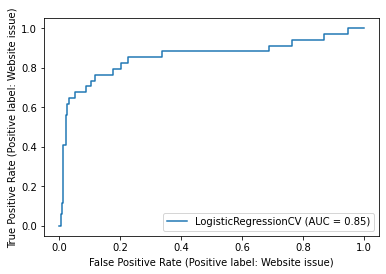

In [ ]:
# plot ROC and calculate auc
from sklearn import metrics
import matplotlib.pyplot as plt
metrics.RocCurveDisplay.from_estimator(mod, X_test, y_test)
plt.show

AUC = 0.85 ie given one of each type, the model will choose the correct type 85% of the time. 
However, given the imbalance of classes, we should also check other metrics, and the confusion matrix, to assess the usefullness of the model.


In [ ]:
# other metrics

from sklearn.metrics import classification_report

y_pred = mod.predict(X_test)
print('Classification Report - Threshold 0.5')
print(classification_report(y_test, y_pred))



Classification Report - Threshold 0.5
                 precision    recall  f1-score   support

Service request       0.94      0.99      0.96       297
  Website issue       0.78      0.41      0.54        34

       accuracy                           0.93       331
      macro avg       0.86      0.70      0.75       331
   weighted avg       0.92      0.93      0.92       331



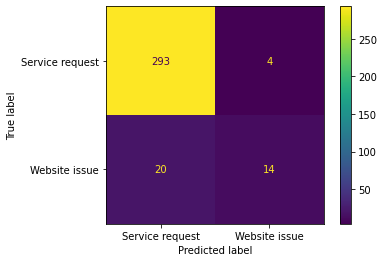

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred, labels=mod.classes_)
cm
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=mod.classes_)
disp.plot()
plt.show()

In [ ]:
y_test.dtypes

Website or service request    category
dtype: object

The model classifies 95% of cases as Sercvice Requests, with 5.4% as Website Issues. We see that the majority of Service Request predictions are accurate (precision = 94%).  
For Website issue predictions, only 78% are actually website related. 
However, due to the imbalance of the classes (10% website related), a significant number of Website issues are mis-classified as Service issues (59%)  



In [ ]:
# convert line break, \n, and comma, to space ' '
#data['Text']=data.Text.replace({"\n": " ",
#                                ",": " ",
#                                ".": " "},regex=True)
# ditto for comma
#data['Text']=data.Text.replace({",": " "},regex=True)

In [ ]:
#data['Website or service request'].value_counts()

Service request    901
Website issue      102
service request      5
website issue        4
Name: Website or service request, dtype: int64

(0.0, 1.0)

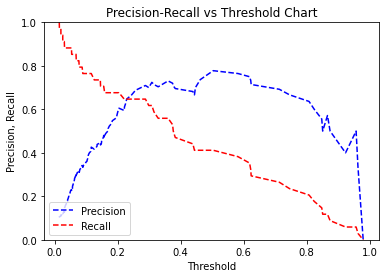

In [ ]:


y_probs=mod.predict_proba(X_test) 
  # probs_y is a 2-D array of probability of being labeled as 0 (first 
 # column of 
  #array) vs 1 (2nd column in array)

from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, y_probs[:,1],
                                                       pos_label = 'Website issue') 
#retrieve probability of being 1(in second column of probs_y)
pr_auc = metrics.auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

Looking at the precision and recall curves (for Website Issue) we see that the recall is approx linear with threshold. ie. Reduce threshold below 0.5 will increase the cases labelled as Website Issue, and hence increase recall.  
In contrast, the precision (% of Website Issue labels that are correct) is approx flat in the range 0.2 - 0.8.  
Therefore we will set to 0.2, and re-evaluate

In [ ]:
# create label at specified threshold

threshold = 0.2
y_lab = y_probs > threshold
#y_testLog = y_test == 'Website issue'
d=pd.DataFrame()
d['true'] = y_test['Website or service request']
d['prob'] = y_probs[:,1]
d = d.assign(pred = ['Website issue' if p > threshold else 'Service request' for p in d['prob']])
d.head(10)
#df = df.assign(col = ['pos' if a > 0 else 'neg' for a in df['a']])

,true,prob,pred
319,Service request,0.028061,Service request
1930,Service request,0.044749,Service request
8,Service request,0.063249,Service request
1998,Service request,0.041032,Service request
4685,Service request,0.013936,Service request
575,Service request,0.027612,Service request
170,Service request,0.023812,Service request
271,Service request,0.019745,Service request
443,Service request,0.058360,Service request
536,Service request,0.149044,Service request


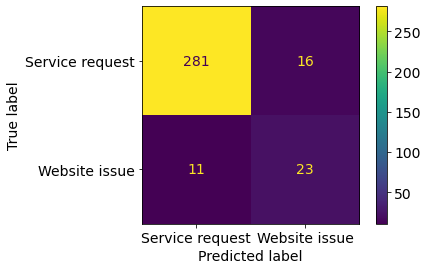

NameError: ignored

In [ ]:
cm2 = confusion_matrix(d.true, d.pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=mod.classes_)
plt.rcParams.update({'font.size': 14})
disp.plot()
plt.show()
plt.rcParams.update(mpl.rcParamsDefault)

In [ ]:
print('Classification Report - threshold ', threshold)
print(classification_report(d.true, d.pred))

Classification Report - threshold  0.2
                 precision    recall  f1-score   support

Service request       0.96      0.95      0.95       297
  Website issue       0.59      0.68      0.63        34

       accuracy                           0.92       331
      macro avg       0.78      0.81      0.79       331
   weighted avg       0.92      0.92      0.92       331



So, by changing the threshold from 0.5 to 0.2, the recall (number of Website issues identified) increases from 41% (of issues) to 68%. The pay off is that the proportion of Website predicitions that are correct falls from 78% to 59% so there are more false positives. (Total number of positive predictions increase from 18 to 39.

In [ ]:
y_lab.dtype

dtype('bool')

In [ ]:
# create label with 1 as website
y_binLabel = np.where(y_test['Website or service request']=='Website issue',1,0)
y_binLabel

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,

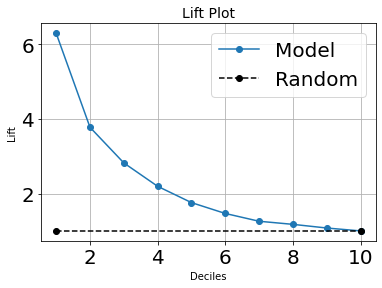

In [ ]:
# look at lift / gain / deciles of probability (of website issue)
# threshold as 0.5

!pip install kds
import kds
#probs = y_probs[:,1]
kds.metrics.plot_lift(y_binLabel, y_probs[:,1])

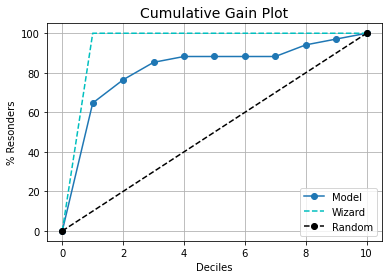

In [ ]:
kds.metrics.plot_cumulative_gain(y_binLabel, y_probs[:,1])

In [ ]:
# look at lift / gain / deciles of probability (of website issue)
# threshold adjusted

#!pip install kds
import kds
#probs = y_probs[:,1]
kds.metrics.plot_lift(d.true, d.prob)

TypeError: ignored